In [58]:
import keras
from keras.layers import Input, Dense, Conv2D, Flatten, BatchNormalization, Activation
from keras.layers.merge import concatenate
from keras.models import Model
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from datetime import datetime
import sqlite3
from blosc import decompress
from msgpack import unpackb
import pandas as pd
import numpy as np
from scipy.stats import entropy

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
%matplotlib inline

# Load data

In [2]:
con = sqlite3.connect("games.sqlite")

In [3]:
def unpack_state(row):
    vec = unpackb(decompress(row.board_state))
    arr = np.array(np.reshape(np.frombuffer(vec, np.uint8), (8, 4, 8)).T, np.float32)
    arr[:, :, 7] /= 100
    return [arr]

In [4]:
def unpack_moves(row):
    vec = unpackb(decompress(row.mcts_moves))
    return [np.reshape(np.array(vec, np.float32), (4, 4, 8)).T]

In [5]:
positions = pd.read_sql_query("select positions.*, games.outcome from positions, games where positions.game_id=games.id", con)
positions['state_tensor'] = positions.apply(unpack_state, axis=1)
positions['moves_tensor'] = positions.apply(unpack_moves, axis=1)
len(positions)

1572434

In [6]:
positions.head()

,id,game_id,move_number,board_state,mcts_moves,mcts_score,outcome,state_tensor,moves_tensor
0,1,1,1,b'\x02\x01\x01\x01\x03\x01\x00\x00\x03\x01\x00...,b'\x02\x01\x01\x01\x83\x02\x00\x00\x83\x02\x00...,0.499667,0.0,"[[[[0. 1. 0. 0. 0. 1. 0. 0.], [0. 1. 0. 0. 0. ...","[[[[0. 0. 0. 0.], [0. 0. 0. 0.], [0. 0. 0. 0.]..."
1,2,1,2,b'\x02\x01\x01\x01\x03\x01\x00\x00\x03\x01\x00...,b'\x02\x01\x01\x01\x83\x02\x00\x00\x83\x02\x00...,0.506500,0.0,"[[[[0. 1. 0. 0. 0. 0. 0. 0.01], ...","[[[[0. 0. 0. 0.], [0. 0. 0. 0.], [0. 0. 0. 0.]..."
2,3,1,3,b'\x02\x01\x01\x01\x03\x01\x00\x00\x03\x01\x00...,b'\x02\x01\x01\x01\x83\x02\x00\x00\x83\x02\x00...,0.495167,0.0,"[[[[0. 1. 0. 0. 0. 1. 0. 0.02], ...","[[[[0. 0. 0. 0.], [0. 0. 0. 0.], [0. 0. 0. 0.]..."
3,4,1,4,b'\x02\x01\x01\x01\x03\x01\x00\x00\x03\x01\x00...,b'\x02\x01\x01\x01\x83\x02\x00\x00\x83\x02\x00...,0.489500,0.0,"[[[[0. 1. 0. 0. 0. 0. 0. 0.03], ...","[[[[0. 0. 0. 0.], [0. 0. 0. 0.], [0. 0. 0. 0.]..."
4,5,1,5,b'\x02\x01\x01\x01\x03\x01\x00\x00\x03\x01\x00...,b'\x02\x01\x01\x01\x83\x02\x00\x00\x83\x02\x00...,0.448167,0.0,"[[[[0. 1. 0. 0. 0. 1. 0. 0.04], ...","[[[[0. 0. 0. 0.], [0. 0. 0. 0.], [0. 0. 0. 0.]..."


## Plot move probabilities

In [7]:
def get_board_coords(layer, vals=None):
    if vals is None:
        vals = layer
    x, y = np.nonzero(layer)
    v = vals[x, y]
    x += 1
    for i, xi in enumerate(x):
        if xi%2 == 1:
            y[i] = y[i]*2 + 2
        else:
            y[i] = y[i]*2 + 1
    return x, y, v

In [120]:
def plot_moves(state_tensor, moves_tensor):  
    for i, sym in [(0, 'ro'), (1, 'ko'), (2, 'r*'), (3, 'k*')]:
        x, y, _ = get_board_coords(state_tensor[:, :, i])
        plt.plot(y, x, sym, markersize=20)

    l = 0.7
    cm = plt.get_cmap('cool')
    for i, (dx, dy) in [(0, (-l, -l)), (1, (l, -l)), (2, (-l, l)), (3, (l, l))]:
        x, y, p = get_board_coords(moves_tensor[:, :, i] > 0.001, moves_tensor[:, :, i])
        for xi, yi, pi in zip(x, y, p):
            plt.arrow(yi, xi, dy, dx, head_width=pi, head_length=0.3, width=pi, color=cm(pi))
            plt.text(yi + dy/1.1, xi + dx/1.1, '{:.2f}'.format(pi), color='g')

    plt.ylim(0.5, 8.5)
    plt.xlim(0.5, 8.5)
    plt.xticks(range(1, 9))
    plt.yticks(range(1, 9))
    
    cr = np.arange(0.5, 9, 1)
    lights = []
    darks = []
    for i in cr:
        for j in cr:
            r = Rectangle((i, j), 1, 1)
            if (int(i)+int(j)) % 2 == 0:
                lights.append(r)
            else:
                darks.append(r)

    plt.gca().add_collection(PatchCollection(lights, facecolor='w', alpha=0.1))
    plt.gca().add_collection(PatchCollection(darks, facecolor='b', alpha=0.1))
    plt.gca().invert_yaxis()

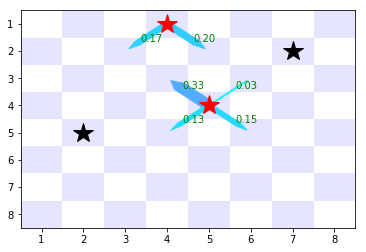

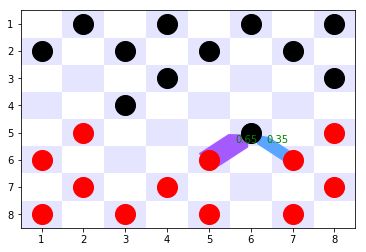

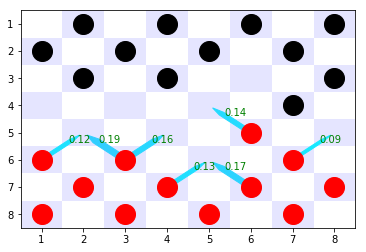

In [121]:
for _, row in positions.sample(3).iterrows():
    plot_moves(row.state_tensor[0], row.moves_tensor[0])
    plt.show()

## Train/validate split

In [10]:
split = positions.groupby(lambda r: positions.loc[r].game_id % 5 == 0)
val = split.get_group(True)
train = split.get_group(False)

In [11]:
def extract_tensors(dataframe):
    inputs = []
    outcomes = []
    mcts_probs = []
    for _, row in dataframe.sample(frac=1).iterrows():
        inputs.append(row.state_tensor[0])
        outcomes.append(row.outcome)
        mcts_probs.append(row.moves_tensor[0].ravel())
    return np.array(inputs), np.array(outcomes), np.array(mcts_probs)

In [12]:
val_in, val_outcomes, val_probs = extract_tensors(val)
train_in, train_outcomes, train_probs = extract_tensors(train)

# Outcome model

In [ ]:
start = Input(shape=positions.loc[0].state_tensor[0].shape)

x = start
for i in range(100):
    prev_layer = x
    x = Conv2D(4, (3, 3), padding='same', activation='relu')(prev_layer)
    x = BatchNormalization()(x)
    x = concatenate([prev_layer, x])
    
x = Conv2D(64, (1, 1), padding='same', activation='relu')(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

outcome_model = Model(start, x)

In [ ]:
savedir = 'logs-outcome/' + str(datetime.now())
tbcb = TensorBoard(log_dir=savedir, histogram_freq=0, write_graph=True, write_images=True)
mccb = ModelCheckpoint(savedir+'/model.{epoch:04d}-{loss:.4f}-{val_loss:.4f}.hdf5',
                       monitor='val_loss', save_best_only=False, period=5)
redlr = ReduceLROnPlateau('loss', factor=0.1, cooldown=1, verbose=1, patience=4)
callbacks = [tbcb, mccb, redlr]

outcome_model.compile(loss='mean_squared_error', optimizer=keras.optimizers.RMSprop(2e-4), metrics=['mean_absolute_error'])
outcome_model.fit(train_in, train_outcomes, 1024, 100, verbose=1, callbacks=callbacks, validation_data=(val_in, val_outcomes))

# MCTS probability model

In [ ]:
start = Input(shape=positions.loc[0].state_tensor[0].shape)

x = start
for i in range(100):
    prev_layer = x
    x = Conv2D(4, (3, 3), padding='same', activation='relu')(prev_layer)
    x = BatchNormalization()(x)
    x = concatenate([prev_layer, x])
    
x = Conv2D(64, (1, 1), padding='same', activation='relu')(x)
x = Conv2D(4, (1, 1), padding='same', activation='relu')(x)
x = Flatten()(x)
x = Activation('softmax')(x)

prob_model = Model(start, x)

In [ ]:
savedir = 'logs-probs/' + str(datetime.now())
tbcb = TensorBoard(log_dir=savedir, histogram_freq=0, write_graph=True, write_images=True)
mccb = ModelCheckpoint(savedir+'/model.{epoch:04d}-{loss:.4f}-{val_loss:.4f}.hdf5',
                       monitor='val_loss', save_best_only=False, period=5)
redlr = ReduceLROnPlateau('loss', factor=0.1, cooldown=1, verbose=1, patience=4)
callbacks = [tbcb, mccb, redlr]

prob_model.compile(loss='kullback_leibler_divergence', optimizer=keras.optimizers.RMSprop(2e-4))
prob_model.fit(train_in, train_probs, 1024, 100, verbose=1, callbacks=callbacks, validation_data=(val_in, val_probs))

# Combined outcome/probability model

In [15]:
start = Input(shape=positions.loc[0].state_tensor[0].shape)

x = start
for i in range(100):
    prev_layer = x
    x = Conv2D(4, (3, 3), padding='same', activation='relu')(prev_layer)
#    x = BatchNormalization()(x)
    x = concatenate([prev_layer, x])

common_output = x

# Move head
x = Conv2D(64, (1, 1), padding='same', activation='relu')(common_output)
x = Conv2D(4, (1, 1), padding='same', activation='relu')(x)
x = Flatten()(x)
move_probs = Activation('softmax', name='move_probs')(x)

# Outcome head
x = Conv2D(64, (1, 1), padding='same', activation='relu')(common_output)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
outcome = Dense(1, activation='sigmoid', name='outcome')(x)

combined_model = Model(start, [move_probs, outcome])

In [ ]:
SVG(model_to_dot(combined_model, True).create(prog='dot', format='svg'))

In [16]:
tag = '100-nobn'
savedir = 'logs-combined/{}-{}'.format(datetime.now().strftime("%Y-%m-%d %H:%M:%S"), tag)
tbcb = TensorBoard(log_dir=savedir, histogram_freq=0, write_graph=True, write_images=True)
mccb = ModelCheckpoint(savedir+'/model.{epoch:04d}-{loss:.4f}-{val_loss:.4f}.hdf5',
                       monitor='val_loss', save_best_only=False, period=5)
redlr = ReduceLROnPlateau('val_loss', factor=0.1, cooldown=1, verbose=1, patience=2)
callbacks = [tbcb, mccb, redlr]

combined_model.compile(loss={'move_probs': 'kullback_leibler_divergence', 'outcome': 'mean_squared_error'},
                   loss_weights={'move_probs': 0.5, 'outcome': 0.5},
                   optimizer=keras.optimizers.RMSprop(2e-4))
combined_model.fit(train_in, [train_probs, train_outcomes], 1024, 100, verbose=1,
               callbacks=callbacks, validation_data=(val_in, [val_probs, val_outcomes]))

Train on 1257431 samples, validate on 315003 samples
Epoch 1/100
1257431/1257431 [==============================] - 601s 478us/step - loss: 0.2412 - move_probs_loss: 0.3783 - outcome_loss: 0.1041 - val_loss: 0.1176 - val_move_probs_loss: 0.1534 - val_outcome_loss: 0.0818
Epoch 2/100
1257431/1257431 [==============================] - 591s 470us/step - loss: 0.0981 - move_probs_loss: 0.1168 - outcome_loss: 0.0794 - val_loss: 0.0890 - val_move_probs_loss: 0.0994 - val_outcome_loss: 0.0787
Epoch 3/100
1257431/1257431 [==============================] - 589s 468us/step - loss: 0.0808 - move_probs_loss: 0.0884 - outcome_loss: 0.0732 - val_loss: 0.0741 - val_move_probs_loss: 0.0768 - val_outcome_loss: 0.0714
Epoch 4/100
1257431/1257431 [==============================] - 588s 467us/step - loss: 0.0738 - move_probs_loss: 0.0774 - outcome_loss: 0.0701 - val_loss: 0.0743 - val_move_probs_loss: 0.0765 - val_outcome_loss: 0.0722
Epoch 5/100
1257431/1257431 [==============================] - 587s 467

KeyboardInterrupt: 

# Plot results on validation set

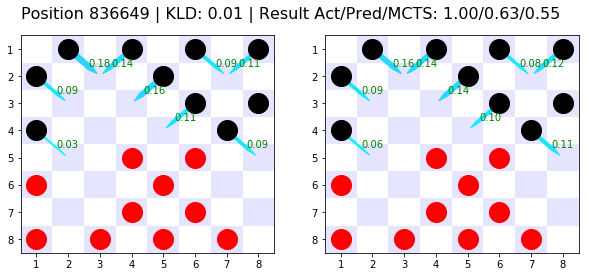

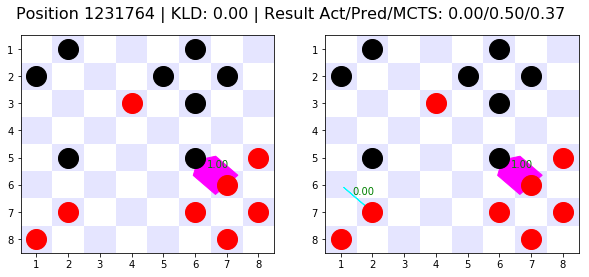

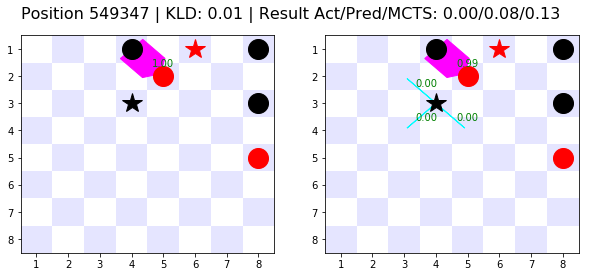

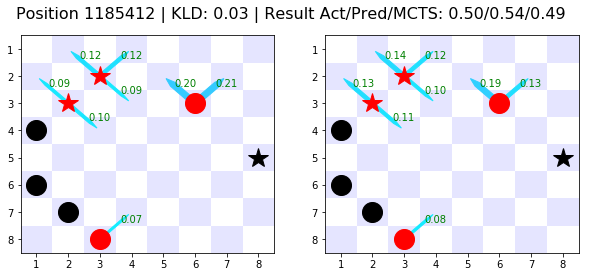

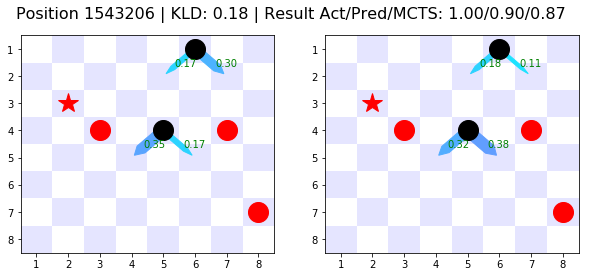

In [210]:
for rowid, row in val.sample(5).iterrows():
    vi = row.state_tensor[0]
    vp = row.moves_tensor[0]
    vpp, vop = combined_model.predict(vi[np.newaxis])
    vpp = np.reshape(vpp, (8, 4, 4))
    
    plt.figure(figsize=(10, 4))
    plt.suptitle("Position {} | KLD: {:.2f} | Result Act/Pred/MCTS: {:.2f}/{:.2f}/{:.2f}".
                 format(rowid, entropy(vp.ravel(), vpp.ravel()), row.outcome, vop[0, 0], row.mcts_score),
                 fontsize=16)
    plt.subplot(1, 2, 1)
    plot_moves(vi, vp)
    plt.subplot(1, 2, 2)
    plot_moves(vi, vpp)
    plt.show()            

In [205]:
def plot_outcome_predictions(game_id, model, positions):
    game = positions[positions.game_id == game_id].sort_values('move_number', ascending=True)
    _move_probs, predictions = model.predict(np.array(game.state_tensor.sum()))
    
    plt.title("Game {}".format(game_id))
    plt.plot(game.mcts_score.as_matrix(), label='MCTS')
    plt.plot(predictions.ravel(), label='Model')
    plt.plot(game.outcome.as_matrix(), label='Actual', lw=4)
    plt.legend()
    plt.ylim(-0.1, 1.1)
    plt.yticks(np.arange(0, 1.01, 0.25))
    plt.grid()

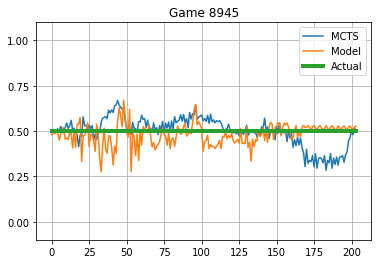

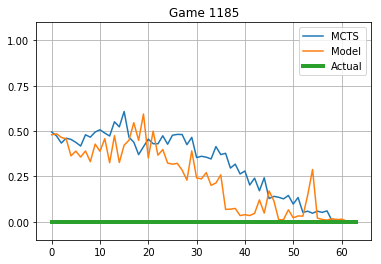

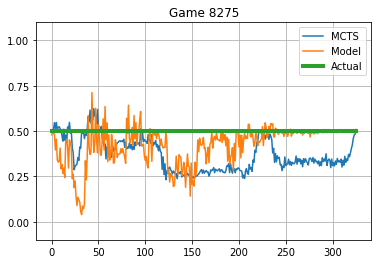

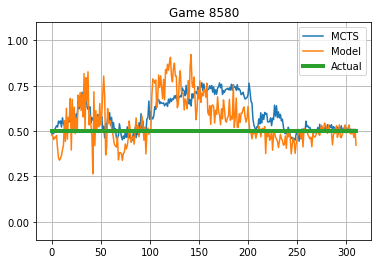

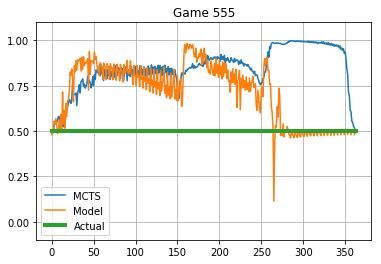

In [209]:
for game_id in np.random.choice(val.game_id.unique(), 5, replace=False):
    plot_outcome_predictions(game_id, combined_model, val)
    plt.show()